In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams; rcParams["figure.dpi"] = 150
import lightkurve as lk
np.random.seed(seed=0)

test TLS on TOI 3353 (best targets: https://docs.google.com/presentation/d/10pso2IFyhF0yCCmgqgzqgis5sY6rNz8y0_bP1ie_lRs/edit#slide=id.gf01058bb40_0_0)

In [7]:
###==============================================
# Load LK
###==============================================
%%time
target_star = "TOI 3353"
lc_item = lk.search_lightcurve(target=target_star, author="SPOC", sector=2)
lc = lc_item.download()
lc_clean = lc.normalize().remove_nans().remove_outliers(sigma_lower=20, sigma_upper=10)

CPU times: user 294 ms, sys: 19.9 ms, total: 314 ms
Wall time: 306 ms


In [4]:
lk.search_lightcurve?

In [14]:
lc_clean.flux.value

array([1.0240986, 1.0237076, 1.0237912, ..., 1.0131259, 1.0125492,
       1.0125917], dtype=float32)

Run TLS

In [15]:
###==============================================
# TLS
###==============================================
from transitleastsquares import transitleastsquares
model = transitleastsquares(lc_clean.time.value, lc_clean.flux.value)
results = model.power()

Transit Least Squares TLS 1.0.28 (13 June 2021)
Creating model cache for 38 durations
Searching 17578 data points, 2390 periods from 0.601 to 13.182 days
Using all 4 CPU threads


100%|█████████████████████████████████████████████| 2390/2390 periods | 01:03<00:00


In [16]:
print('Period', format(results.period, '.5f'), 'd')
print(len(results.transit_times), 'transit times in time series:', \
        ['{0:0.5f}'.format(i) for i in results.transit_times])
print('Transit depth', format(results.depth, '.5f'))
print('Best duration (days)', format(results.duration, '.5f'))
print('Signal detection efficiency (SDE):', results.SDE)

Period 3.35362 d
8 transit times in time series: ['1356.05522', '1359.40885', '1362.76247', '1366.11609', '1369.46972', '1372.82334', '1376.17696', '1379.53058']
Transit depth 0.96584
Best duration (days) 0.36618
Signal detection efficiency (SDE): 4.983817865152437


and visualize the results

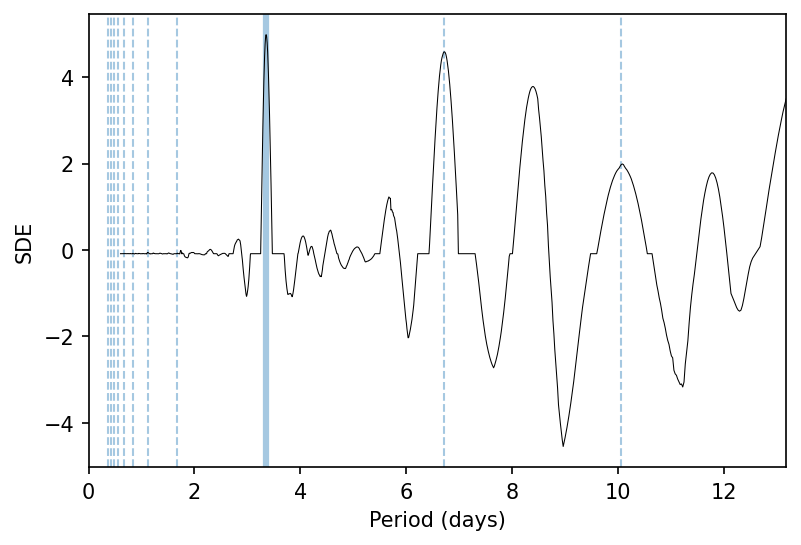

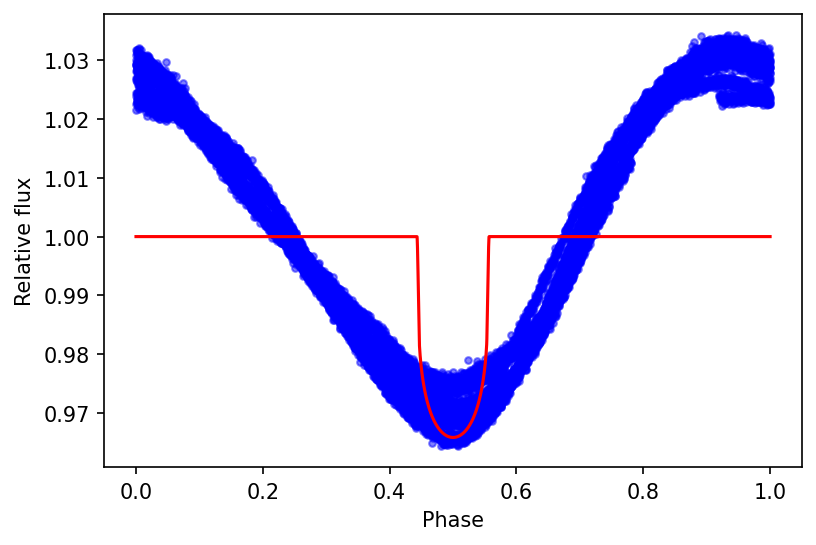

In [26]:
plt.figure()
ax = plt.gca()
ax.axvline(results.period, alpha=0.4, lw=3)
plt.xlim(np.min(results.periods), np.max(results.periods))
for n in range(2, 10):
    ax.axvline(n*results.period, alpha=0.4, lw=1, linestyle="dashed")
    ax.axvline(results.period/n, alpha=0.4, lw=1, linestyle="dashed")
plt.ylabel(r'SDE')
plt.xlabel('Period (days)')
plt.plot(results.periods, results.power, color='black', lw=0.5)
plt.xlim(0, max(results.periods))

plt.figure()
plt.plot(results.model_folded_phase, results.model_folded_model, color='red')
plt.scatter(results.folded_phase, results.folded_y, color='blue', s=10, alpha=0.5, zorder=2)
#plt.xlim(0.48, 0.52)
plt.ticklabel_format(useOffset=False)
plt.xlabel('Phase')
plt.ylabel('Relative flux');

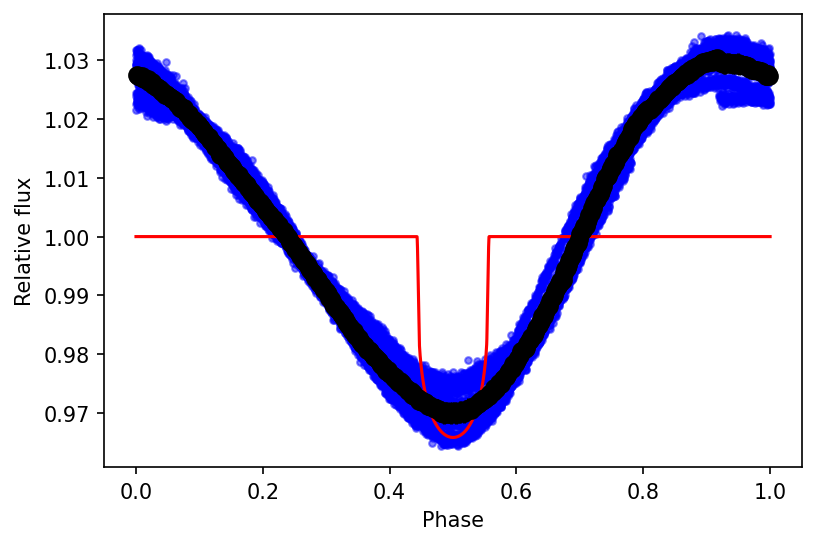

In [28]:
from scipy import stats
bins = 500
bin_means, bin_edges, binnumber = stats.binned_statistic(
    results.folded_phase,
    results.folded_y,
    statistic='mean',
    bins=bins)
bin_stds, _, _ = stats.binned_statistic(
    results.folded_phase,
    results.folded_y,
    statistic='std',
    bins=bins)
bin_width = (bin_edges[1] - bin_edges[0])
bin_centers = bin_edges[1:] - bin_width/2

plt.plot(results.model_folded_phase, results.model_folded_model, color='red')
plt.scatter(results.folded_phase, results.folded_y, color='blue', s=10, alpha=0.5, zorder=2)
plt.errorbar(
    bin_centers,
    bin_means,
    yerr=bin_stds/2,
    xerr=bin_width/2,
    marker='o',
    markersize=8,
    color='black',
    #capsize=10,
    linestyle='none')
#plt.xlim(0.48, 0.52)
plt.ticklabel_format(useOffset=False)
plt.xlabel('Phase')
plt.ylabel('Relative flux');

Questions:<br>
what is the error message of Load LK cell ??? <br>
how does the 